In [2]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/pendulum\ sys\ id/


Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/pendulum sys id


In [3]:
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import math

g = 9.81  # (m/s^2)  gravity constant
dt = 0.01  # time_step for discrete-time system

def system_parameters():
    m = 0.1  # (kg)    mass
    l = 0.5  # (m) distance between the rotor and the center of mass
    k = 0.1  # controller gain
    return m, l, k

def generate_u(input_, time_hor, s_, mean, std, u_max, lb, ub):  # noise in control input
    if input_ == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        return r1
    elif input_ == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1
    elif input_ == "bernouli":
        np.random.seed(s_)
        r0 = np.random.rand(time_hor)
        r1 = []
        for k in range(len(r0)):
          if r0[k] < 0.5:
            r1.append(0.5)
          else:
            r1.append(-0.5)
        return r1

def generate_w(distr, time_hor, s_, mean, std, w_max, lb, ub):  # disturbance
    if distr == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        return r1, r2
    elif distr == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2
    elif distr == "bernouli":
        np.random.seed(s_)
        r01 = np.random.rand(time_hor)
        r02 = np.random.rand(time_hor)
        r1 = []
        r2 = []
        for k in range(len(r01)):
          if r01[k] < 0.5:
            r1.append(100)
          else:
            r1.append(-100)
        for k in range(len(r02)):
          if r02[k] < 0.5:
            r2.append(100)
          else:
            r2.append(-100)
        return r1, r2

class SimplePendulumDynamics:
    def __init__(self, distr, input):
        self.state = None
        self.u0 = None
        self.distr = distr
        self.input = input
        self.m, self.l, self.k = system_parameters()
        self.alpha_list = []
        self.omega_list = []
        self.phi_s_u_list = []
        self.b_s_list = []
        self.phi_list = []
        self.state_list = []

    def plot_trajectory(self):
        t_list = np.array(range(len(self.alpha_list))) * dt
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)   # wspace: space between subplots in a row

        axs[0].plot(t_list, np.array(self.alpha_list), label='$\\alpha$')
        axs[0].set_xlabel('time (s)')
        axs[0].set_ylabel('$\\alpha$ ($rad$)')
        axs[0].legend()

        axs[1].plot(t_list, self.omega_list, label='$\omega$')
        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('$\omega$ ($rad/s^{2}$)')
        axs[1].legend()

        plt.show()

    def update_feature_list(self, phi_s_u, s_, s, ex):
        self.phi_s_u_list.append(phi_s_u)
        self.b_s_list.append(s - s_ - ex)

    def update_feat(self, y):
        self.phi_list.append(y)


    def get_trajectory_3(self, x0, time_hor, s_u, s_w, param_u, mult_u, param_w, mult_w):

        # ----------------------------------------- initial states -----------------------------------------------------
        self.state = x0
        x = np.array(x0)
        alpha_ = x[0]  # angle
        omega_ = x[1]  # angular velocity

        #  ------------------------------------- Storing the states - ---------------------------------------------
        self.alpha_list = [alpha_]
        self.omega_list = [omega_]
        self.state_list = [np.array([alpha_, omega_])]

        if self.input == "trunc_guass":
          u_max_ = param_u[2]
        else:
          u_max_ = 1.0

        if self.distr == "trunc_guass":
          w_max_ = param_w[2]
        else:
          w_max_ = 1.0

        # -----------------  random noise and disturbance generation ---------------------------------------------------
        U1_list = generate_u(self.input, time_hor, s_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
        W1_list, W2_list = generate_w(self.distr, time_hor, s_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])

        for t in range(time_hor):

            s_ = omega_

            # ------------------  noise in control input  (for exploration)  ----------------------------------------
            u1 = U1_list[t]

            # ----------------   noise in control input  (for exploration)  -----------------------------------------
            w1 = mult_w[0] * W1_list[t]
            w2 = mult_w[1] * W2_list[t]

            # ----------------------------------------  PD control + noise  ------------------------------------------
            u = - self.k * omega_ + u1

            # ------------------------------------------  Dynamic model ----------------------------------------------
            alpha_dot = omega_ + w1
            omega_dot = - g * math.sin(alpha_) / self.l + u / (self.m * self.l * self.l) + w2

            phi_s_u = np.array([-g*math.sin(alpha_), u])
            self.update_feat(phi_s_u)

            # -------------------------------------- Updating the states --------------------------------------------
            alpha = alpha_ + dt * alpha_dot
            omega = omega_ + dt * omega_dot

            self.state = np.array([alpha, omega])

            s = omega

            self.update_feature_list(dt * phi_s_u, s_, s, 0)

            omega_ = omega
            alpha_ = alpha

            # ------------------------------------- Storing the states ----------------------------------------------
            self.alpha_list.append(alpha)
            self.omega_list.append(omega)
            self.state_list.append(np.array([alpha, omega]))

In [4]:
# --------------------------import packages-------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

# ----------------------import classes and functions----------------------------
# from pendulum_dynamics import SimplePendulumDynamics

# --------------------------ground_truth parameters-----------------------------
m, l, _ = system_parameters()
ground_truth = [1 / l, 1 / m / l / l]
print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 1             # number trajectories
max_time_hor = 2002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
disturbance: str = "trunc_guass"
parameter_dist = [0.0, 1, 1]  # mean and std

# disturbance: str = "bernouli"

# disturbance: str = "uniform"
# parameter_dist = [-1, 1]  # lb and ub

mult_w = [1, 1]
seeds_w = range(300, 500) # fixing seeds
w_max = 0.01             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
c_input: str = "trunc_guass"
parameter_input = [0.0, 2, 1]  # mean and std and scale

# c_input: str = "bernouli"

# c_input: str = "uniform"
# parameter_input = [-1, 1]  # lb and ub

mult_u = [1]
seeds_u = range(100, 300)   # fixing seeds


print('------------------Getting Trajectory Data of Quadrotor-----------------')
# theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []
Phi_list = []
State_list = []

for e in range(n_epoch):
  x0 = [0.0 , 0.0]
  pend = SimplePendulumDynamics(c_input, disturbance)
  pend.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist, mult_w)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # pend.plot_trajectory()

  Delta_S_list.append(pend.b_s_list)
  Phi_S_U_list.append(pend.phi_s_u_list)     # nonlinear feature vector

  Phi_list.append(pend.phi_list)
  State_list.append(pend.state_list)

print('-------------------------------Data Saved------------------------------')


-----------------------------------------------------------------------
ground truth =  [2.0, 40.0]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
-------------------------------Data Saved------------------------------


In [5]:
# ----------------------import packages-------------------------------------
import numpy as np
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix

from set_membership_lin_prog_pend import run_set_membership

w_max = 0.01

time_hor = range(2, 2002, 1)

intersection_points = []
mean_diam_list = []
std_diam_list = []
print('-------------------------------Run SME---------------------------------')
for k in range(len(time_hor)):
  print('T = ' + str(time_hor[k]))
  print('-------------------------------------------------------------------')
  intersection_points_ = []
  diam_list = []
  # volume_list = []
  for e in range(n_epoch):
    print('epoch = ' + str(e+1))
    points, _ = run_set_membership(Delta_S_list[e][:time_hor[k]], Phi_S_U_list[e][:time_hor[k]], w_max)
    # hull_ = ConvexHull(points)
    # volume_list.append(hull_.volume)
    distances_ = distance_matrix(points, points)
    diam_list.append(np.max(distances_))
    intersection_points_.append(points)
  mean_diam_list.append(np.mean(np.array(diam_list), axis=0))
  # alpha = 0.05  # 95% confidence interval
  # z_score = norm.ppf(1 - alpha / 2)
  # coeff = z_score / np.sqrt(n_epoch)
  coeff = 1
  std_diam_list.append(coeff * np.std(np.array(diam_list), axis=0))
  intersection_points.append(intersection_points_)

print('---------------------------------Done!---------------------------------')

Streaming output truncated to the last 5000 lines.
Optimal solution found.
T = 1645
-------------------------------------------------------------------
epoch = 1
---------------------- finding a feasible point by cvxopt -- T =  1645  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.2900e+01  3e+03  2e+00  0e+00  1e+00
 1:  0.0000e+00 -2.3718e-01  9e-01  5e-02  9e-15  4e-01
 2:  0.0000e+00 -6.1482e-02  8e-02  4e-03  1e-15  3e-03
 3:  0.0000e+00 -4.4980e-03  5e-03  3e-04  9e-16  3e-04
 4:  0.0000e+00 -1.4437e-03  1e-03  1e-04  6e-16  6e-05
 5:  0.0000e+00 -3.8630e-05  4e-05  3e-06  6e-16  1e-06
 6:  0.0000e+00 -3.9954e-07  4e-07  3e-08  4e-17  2e-08
 7:  0.0000e+00 -3.9953e-09  4e-09  3e-10  4e-19  2e-10
Optimal solution found.
T = 1646
-------------------------------------------------------------------
epoch = 1
---------------------- finding a feasible point by cvxopt -- T =  1646  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:

In [6]:
def plot_polygons(ax, inter_points, color_, alpha_, label_):
    n_points = np.zeros((inter_points.shape[0], 2))
    n_points[:, 0] = inter_points[:, 0]
    n_points[:, 1] = inter_points[:, 1]

    hull = ConvexHull(n_points)

    # for simplex in hull.simplices:
    #     ax.plot(n_points[simplex, 0], n_points[simplex, 1], color=color_, linewidth=1)
    ax.fill(n_points[hull.vertices, 0], n_points[hull.vertices, 1], alpha=alpha_, color=color_, label=label_)

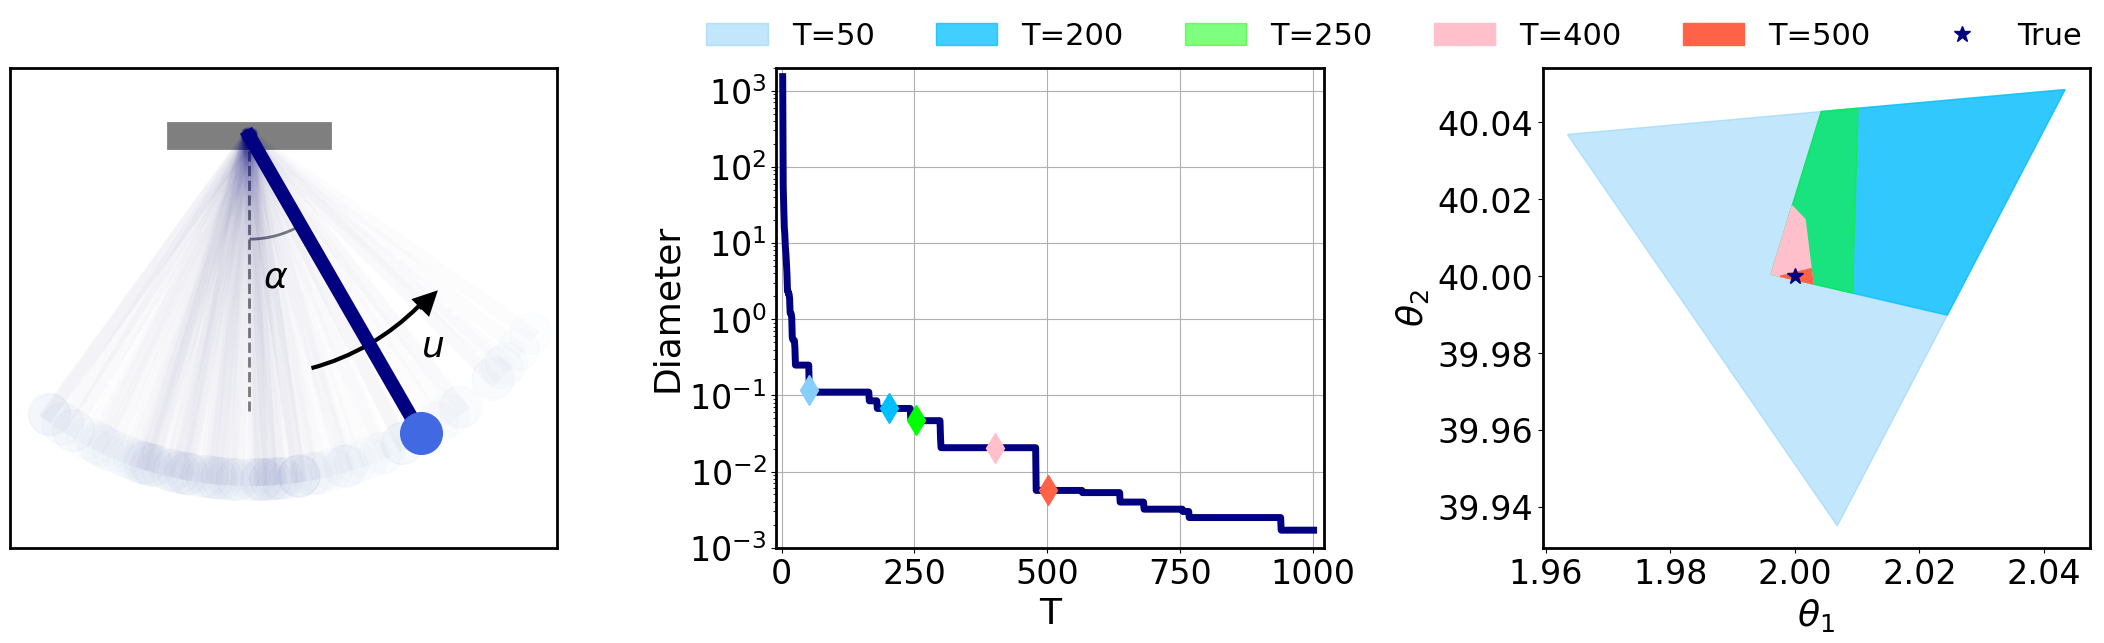

In [10]:
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

from matplotlib.patches import Arc

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2

max_ind = 1000
state_alpha = pend.alpha_list[:max_ind] # [::5]
state_omega = pend.omega_list[:max_ind]
mean_diam_list = mean_diam_list[:max_ind]
intersection_points = intersection_points[:max_ind]
t_list = time_hor[:max_ind]

fig, axs = plt.subplots(1, 3, figsize=(26, 6))
# fig, axs = plt.subplots(1, 3, figsize=(28, 8))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.2)

#####################################################################################################################
m = 5
eps = 0.1
axs[0].plot([-eps, eps],[0, 0], color='tab:gray', lw=20)
axs[0].plot([0, 0], [0, -0.4], color='tab:gray', linestyle='--' ,lw=2)
axs[0].add_patch(Arc((0, 0), .3, .3, theta1=-90, theta2=-90+30, linewidth=2, color='tab:gray'))
axs[0].text(0.02, -0.22, '$\\alpha$', fontdict=None)

axs[0].add_patch(Arc((0, 0), .7, .7, theta1=-75, theta2=-75+30, linewidth=3, color='black'))
axs[0].arrow(0.25, -0.25, 0.001, 0.001, head_width=0.03, head_length=0.03, fc='black', ec='black', linewidth=2)
axs[0].text(0.25, -0.32, '$u$', fontdict=None)

# axs[0].text(-0.25, 0.2, '$u = -k \dot{\\alpha} + \eta$', fontdict=None)

m = 10
for i in range(int(len(intersection_points)/m)-1):
  axs[0].plot([0, l*np.sin(state_alpha[m*i])],[0, -l*np.cos(state_alpha[m*i])], color='navy', lw=10, alpha=0.01)
  axs[0].plot(l*np.sin(state_alpha[m*i]), -l*np.cos(state_alpha[m*i]), marker='o', color='royalblue', markersize=30, alpha=0.01)
th = np.pi/6
axs[0].plot([0, l*np.sin(th)],[0, -l*np.cos(th)], color='navy', lw=10)
axs[0].plot(l*np.sin(th), -l*np.cos(th), marker='o', color='royalblue', markersize=30)
# axs[0].set_xlim([-l-eps, l+eps])
# axs[0].set_ylim([-l-eps, l+eps])
axs[0].set_xlim([-l/2-eps, l/2+2*eps])
axs[0].set_ylim([-l-eps, eps])
axs[0].set_xticks([])
axs[0].set_yticks([])
# axs[0].set_title('(a) pendulum')
axs[0].grid(False)
# axs[0].set_aspect('equal', adjustable='box')

#####################################################################################################################

lw_ = 5
color_ = 'navy'
axs[1].plot(t_list, mean_diam_list, lw=lw_, color=color_)

lw_ = 5
color_ = 'lightskyblue'
axs[1].plot(t_list[50], mean_diam_list[50], lw=lw_, color=color_, marker='d', markersize=15)

lw_ = 5
color_ = 'deepskyblue'
axs[1].plot(t_list[200], mean_diam_list[200], lw=lw_, color=color_, marker='d', markersize=15)

lw_ = 5
color_ = 'lime'
axs[1].plot(t_list[250], mean_diam_list[250], lw=lw_, color=color_, marker='d', markersize=15)

lw_ = 5
color_ = 'pink'
axs[1].plot(t_list[400], mean_diam_list[400], lw=lw_, color=color_, marker='d', markersize=15)

lw_ = 5
color_ = 'tomato'
axs[1].plot(t_list[500], mean_diam_list[500], lw=lw_, color=color_, marker='d', markersize=15)


axs[1].set_yscale('log')
axs[1].set_xlim([0-10, max_ind+20])
axs[1].set_ylim([0.001, 2000])
axs[1].set_xlabel('T')
axs[1].set_ylabel('Diameter')
# axs[1].set_title('(b) uncertainty set diamater')
axs[1].grid(True)

#####################################################################################################################

alpha_ = 0.5
color_ = 'lightskyblue'
plot_polygons(axs[2], intersection_points[50][0], color_, alpha_, 'T=50')
alpha_ = 0.75
color_ = 'deepskyblue'
plot_polygons(axs[2], intersection_points[200][0], color_, alpha_, 'T=200')
alpha_ = 0.5
color_ = 'lime'
plot_polygons(axs[2], intersection_points[250][0], color_, alpha_, 'T=250')
alpha_ = 1
color_ = 'pink'
plot_polygons(axs[2], intersection_points[400][0], color_, alpha_, 'T=400')
alpha_ = 1
color_ = 'tomato'
plot_polygons(axs[2], intersection_points[500][0], color_, alpha_, 'T=500')

axs[2].set_xlabel('$\\theta_{1}$')
axs[2].set_ylabel('$\\theta_{2}$')
# axs[2].set_title('(c) uncertainty set')
axs[2].grid(False)

color__ = 'navy'
axs[2].plot(ground_truth[0], ground_truth[1], '*', markersize=12, markerfacecolor=color__, markeredgecolor=color__, label='True')
# axs[2].set_xlim([1.96, 2.045])
# axs[2].set_ylim([39.95, 40.01])
# axs[2].legend(edgecolor='white', facecolor='white', framealpha=1, loc=(1.01, 0.1))
axs[2].legend(ncol=6, edgecolor='white', facecolor='white', framealpha=1, loc=(-1.55, 1.01))

# axs[0].text(-0.35, -0.9, '(a) pendulum', fontdict=None, size=28)
# axs[0].text(1.2, -0.9, '(b) uncertainty set diamater', fontdict=None, size=28)
# axs[0].text(3.3, -0.9, '(c) uncertainty set', fontdict=None, size=28)

#####################################################################################################################


plt.show()

